# Chapter 5
## Compressing data via dimensionality reduction

Instead of simply choosing a subset of features to reduce dimensionality, *feature extraction* can also be used. This is when data is projected onto a new feature space, without loosing data information.  This not only improves resource use, but can also prevent the curse of dimensionality.  This becomes important when using non-regularized models.

## Main steps in Principle Component Analysis

*Principle component analysis* (PCA) tries to find directions of maximum variance in high dimensional datasets, then projects the data onto a space with fewer dimensions.  

A transformation matrix, $W = d \times k$, that transforms a training record $x$ onto a $k$-dimensional feature space.  If:
$$
    x = [x_1, \dots, x_d] \in \mathbb{R}^d
$$
Then apply $W$ to $x$:
$$
    xW = z
$$
such that
$$
    z = [z_1, \dots, z_k] \in \mathbb{R}^k
$$
where $k<d$, typically $k \ll d$.

The algorithm can be summarized in the following steps:
1. Standardize the $d$-dimensional feature space
2. Construct the covariance matrix, $\Sigma$
3. Decompose $\Sigma$ into eigenvectors and eigenvalues
4. Sort eigenvalues in decreasing order to rank the corresponding eigenvectors
5. Select $k$ eigenvectors based on their eigenvalues; $k$ is the dimensionality of the new feature space  
6. Construct the transformation matrix, $W$, from the $k$ eigenvectors
7. Transform the dataset, $X$, via $W$

More information:
- [Eigenvectors](https://mathworld.wolfram.com/Eigenvector.html)
    - recall that the characteristic polynomial must have zero roots, in this case they should be real valued, not complex valued.
    - also note that $\text{det} (A- \lambda I) = 0$, which leads to a reduction in dimensions
- [Determinant](https://en.wikipedia.org/wiki/Determinant)
    - note: "... the determinant is nonzero if and only if the matrix is invertible and the linear map represented by the matrix is an isomorphism."
- [Eigen decomposition](https://mathworld.wolfram.com/EigenDecomposition.html)

## Extracting principle components step by step
1. data is split and standardized

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
df_wine = pd.read_csv('wine_data.csv').drop(columns = ['Unnamed: 0'])
#use a .7/.3 split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

2. compute the covariance matrix

The covariance matrix, $\Sigma$, is the matrix that stores the pairwise covariances between features:
$$
    \sigma_jk = \frac{1}{n-1} \sum_{i=1}^n (x_j^{(i)} - \mu_j)(x_k^{(i)} - \mu_k)
$$

The eigenvectors of $\Sigma$ will be the principle components of teh maximum variance

In [2]:
cov_mat = np.cov(X_train_std.T)

3. compute the eigenvalues and eigenvectors
Recall the definition of eigenvectors:
$$
    \Sigma v = \lambda v
$$
where $v$ is the eigenvector and $\lambda$ is the eigenvalue.

(Note that the characteristic polynomial might have complex roots, but numpy has the `numpy.linalg.eigh` method which will use Hermetian matrices; these will be real valued eigenvectors).

In [3]:
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
eigen_vals

array([4.84274532, 2.41602459, 1.54845825, 0.96120438, 0.84166161,
       0.6620634 , 0.51828472, 0.34650377, 0.3131368 , 0.10754642,
       0.21357215, 0.15362835, 0.1808613 ])

### Total and explained variance

To map to a lower dimension feature space, only the eigenvectors with the highest variance are selected. This is determined by the explained variance ratio
$$
    \frac{\lambda_j}{\sum_{j=1}^d \lambda_j}
$$

This is calculated using the cumulative sum function in numpy, `cumsum`.  Note that the first two components account for almost 0.6 of the variance.

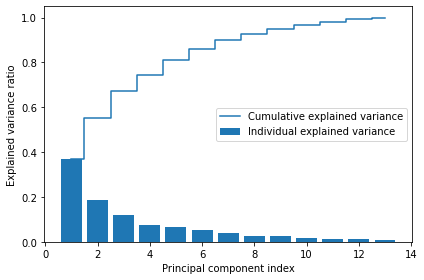

In [4]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)
import matplotlib.pyplot as plt
plt.bar(range(1,14), var_exp, align='center', label='Individual explained variance') 
plt.step(range(1,14), cum_var_exp, where='mid', label='Cumulative explained variance') 
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Feature transformtion

1. Select $k$ eigenvectors, where $k$ is the required dimensions

In [5]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k : k[0], reverse = True)

2. Get the $k$ eigenvectors to make $W$, the transformation matrix.

Note that $W$ is a $13 \times 2$, so the new feature space with be $1 \times 2$; recalling: $xW = z$

In [6]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
w

array([[-0.13724218,  0.50303478],
       [ 0.24724326,  0.16487119],
       [-0.02545159,  0.24456476],
       [ 0.20694508, -0.11352904],
       [-0.15436582,  0.28974518],
       [-0.39376952,  0.05080104],
       [-0.41735106, -0.02287338],
       [ 0.30572896,  0.09048885],
       [-0.30668347,  0.00835233],
       [ 0.07554066,  0.54977581],
       [-0.32613263, -0.20716433],
       [-0.36861022, -0.24902536],
       [-0.29669651,  0.38022942]])

Now apply the trasnformation matrix to obtain $x'$

In [7]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

## Principal component analysis in scikit-learn

`PCA` class in scikit-learn is a transformer. 

In [8]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

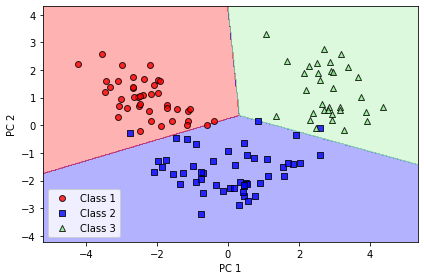

In [9]:
from sklearn.linear_model import LogisticRegression 
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
lr = LogisticRegression(multi_class = 'ovr', random_state = 1, solver = 'lbfgs')
X_train_pca = pca.fit_transform(X_train_std)
X_test_pcs = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

PCA is also useful for calculating the explained variance by passing `None` for `n_components`.

In [10]:
pca = PCA(n_components = None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

### Assessing feature contributions

- *loadings* : how much each individual feature contributes to a given principle component.  It is equal to $v\sqrt{\lambda}$, eigenvector scaled by the square root of the eigenvalue.

Note that these are correlations: a value of $1$ is a strong positive correlations and $-1$ is a strong negative correlation.  Features $6$ and $7$ are the strongest negative correlations, and $8$ is strongly positive correlation.

In [13]:
loadings = eigen_vecs * np.sqrt(eigen_vals)
#can also use the scikitlearn object
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

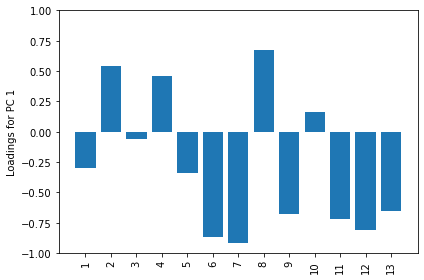

In [14]:
fig, ax = plt.subplots()
ax.bar(range(13), loadings[:, 0], align='center') 
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90) 
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

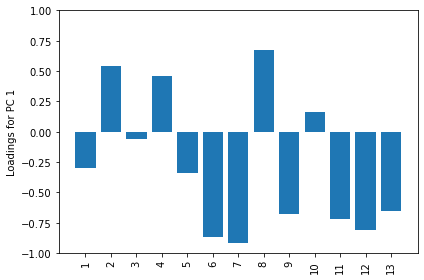

In [15]:
#plot for scikitlearn loadings
fig, ax = plt.subplots()
ax.bar(range(13), sklearn_loadings[:, 0], align='center') 
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90) 
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

## Supervised data compression via linear discriminant analysis
The goal of *linear discriminant analysis* (LDA) is to find feature subspaces that optimize class seperability. Like PCA, it is a linear transformation technique; therefore, it finds a transformtion matrix, $W$, such that $xW=z$ where $z$ is in a feature subspace. LDA assumes:
- Data is normally distributed
- Classes have identical covariance matrices
- Training samples are independent of each other
However, LDA can work reasonably well when these are violated slightly.

### LDA workings

1. standardize $d$ dimensional dataset
2. for each class compute the $d$ dimensional mean vector
3. construct a between-class scatter matrix, $S_B$, and a within class scatter matrix, $S_W$.
4. computer eigenvectors and eigenvalues of $S_B^{-1}S_B$
5. sort eigenvalues in decreasing order, and sort their corresponding eigenvectors
6. choose $k$ eigenvectors that correspond to the $k$ largest eigenvalues and use these as the columns of the $W$ transformation matrix
7. use $W$ to project the features onto the new feature subspace

Note that the algorithm is very similar to PCA; however, the mean (in the form of a mean vector for each class and scatter matrices) is used which assumes that there are already existing class groupings.

#### Computing scatter matrices
(example will use the already stadardized `df_wine` dataset)

Computing the scatter matrices first requires the computation of the mean vectors for each of $i$ classes:
$$
    m_i = \frac{1}{n_i} \sum_{x \in D_i} x_m
$$
This makes a mean vector for each class.  The mean vector for the $i$th class, $m_i$, looks like:
$$
    m_i = \left[\begin{matrix} \mu_1 \\ \vdots \\ \mu_k \end{matrix}\right]
$$
where $k$ is the number of features.

In [17]:
mean_vecs = list()
for label in range(1,4):
    mean_vecs.append(
        np.mean(X_train_std[y_train==label], axis = 0) #take the mean along the column (axis = 0)
    )
    print(f'MV {label}: {mean_vecs[label - 1]}\n')

MV 1: [ 0.9065826  -0.34973457  0.32010329 -0.71891449  0.50558678  0.88069702
  0.95894709 -0.55161049  0.54159322  0.23383109  0.58971299  0.65631399
  1.20749382]

MV 2: [-0.87487963 -0.28480003 -0.37347228  0.31571225 -0.38480347 -0.04332505
  0.06345321 -0.09460613  0.07034749 -0.82860474  0.31436962  0.36084258
 -0.72528643]

MV 3: [ 0.199215    0.8660339   0.168163    0.41484489 -0.04511771 -1.02855532
 -1.28756034  0.82867687 -0.77947565  0.96494432 -1.20899133 -1.36215159
 -0.40130076]



Using the mean vectors, we can compute the scatter matrices.  Within class:
$$
    S_W = \sum_{i=1}^c S_i
$$
where we sum the scatter matrix for each class:
$$
    S_i = \sum_{x \in D_i} (x - m_i)(x - m_i)^T 
$$

(Note, we are adding matrices in each sum, so the overall sum is a matrix)

In [26]:
d = 13 #number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
print(f'Within-class scatter matrix: {S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix: 13x13


Note that the labels are not evenly distributed:

In [27]:
print(f'Class label distribution: {np.bincount(y_train)[1:]}')

Class label distribution: [41 50 33]


This is contrary to the assumptions of LDA. Therefore, each $S_i$ needs to be scaled before summing as $S_W$.  In order to scale, we divide by $n_i$, the number of examples in class $i$:
$$
    \frac{1}{n_i} \sum_{x \in D_i} (x - m_i)(x - m_i)^T
$$
Note that this is the covariance matrix for the $i$th class, $\Sigma_i$.

In [29]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label,mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
print(f'Scaled within-class scatter matrix: {S_W.shape[0]}x{S_W.shape[1]}')

Scaled within-class scatter matrix: 13x13


Now compute the between class scatter matrix:
$$
    S_B = \sum_{i=1}^c n_i(m_i - m)(m_i - m)^T
$$
where $m$ is the overall mean (i.e. includes data from all classes).

In [30]:
mean_overall = np.mean(X_train_std, axis=0) 
mean_overall = mean_overall.reshape(d, 1)
d = 13 # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1) # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print(f'Between-class scatter matrix: {S_B.shape[0]}x{S_B.shape[1]}')

Between-class scatter matrix: 13x13
